In [1]:
library(mmge)
library(expm)
library(MASS)

Loading required package: Matrix

Attaching package: ‘expm’

The following object is masked from ‘package:Matrix’:

    expm



In [2]:
devtools::reload(pkg=".")

ℹ Reloading attached mmge


# 1. generate shared graph structure

In [3]:
m = 5
n = 5
p = 100
q = 30

In [4]:
g = ceiling(q/10)

In [5]:
g.ind = sort(sample(g, q, replace=TRUE))

In [6]:
Adj.S = matrix(0, q, q)
for(i in 1:g){
    tmp = which(g.ind==i)
    Adj.S[tmp[1],tmp[-1]] = 1
}
Adj.S = Adj.S + t(Adj.S)

# 2. generate precision matrices

## spatial precision matrix

In [8]:
power.S = 0.3

In [9]:
Omega.S = lapply(rep(0,m), function(x){
    Omega = matrix(0,q,q)
    Omega[upper.tri(Omega)] = (
        - runif(q*(q-1)/2, 0, power.S) * Adj.S[upper.tri(Adj.S)])
    Omega = Omega + t(Omega)
    if(min(eigen(Omega)$values)<0){
        Omega = Omega - 2*min(eigen(Omega)$values)*diag(q)
    }
    return(Omega)
})
Sigma.S = lapply(Omega.S, solve)

In [10]:
Rho.S = lapply(Omega.S, function(x){
    dgWh.S = array(rep(diag(x), q), c(q,q))
    return(x / aperm(sqrt(dgWh.S), c(2,1)) / sqrt(dgWh.S))
})

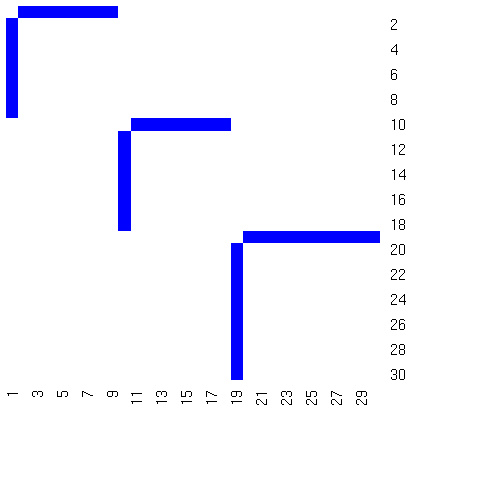

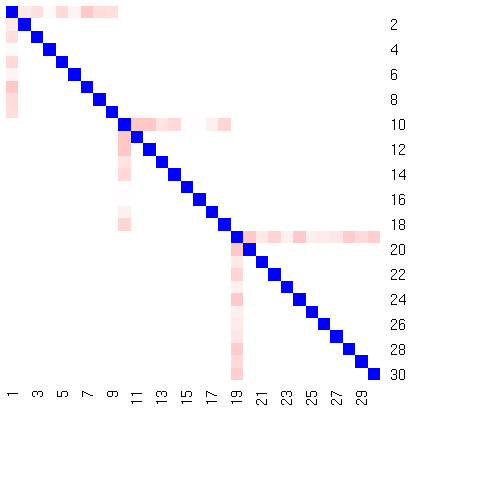

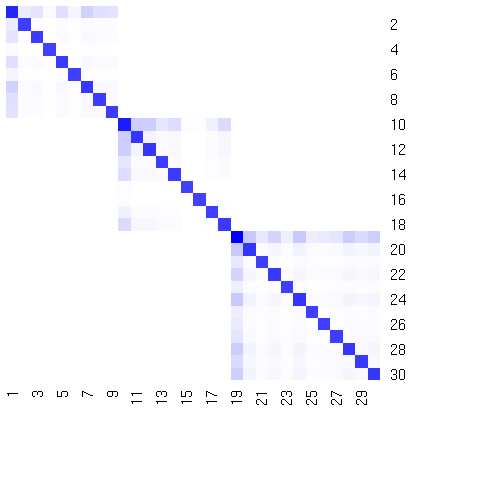

In [11]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(Omega.S[[1]])
imshow(Sigma.S[[1]])

## temporal precision matrix

In [12]:
power.T = 0.2
decay.T = 1

In [13]:
beta.T = power.T * abs(outer(1:p,1:p,FUN='-'))**(-1-decay.T)
beta.T[upper.tri(beta.T, diag=TRUE)] = 0

In [14]:
Omega.T = lapply(rep(0, m), function(x){
    t(diag(p)-beta.T) %*% (diag(p)-beta.T)})
Sigma.T = lapply(Omega.T, solve)

In [15]:
Omega.T = lapply(1:m, function(l){
  Omega.T[[l]] * sum(diag(Sigma.T[[l]])) / p  
})

Sigma.T = lapply(1:m, function(l){
  Sigma.T[[l]] * p / sum(diag(Sigma.T[[l]]))
})

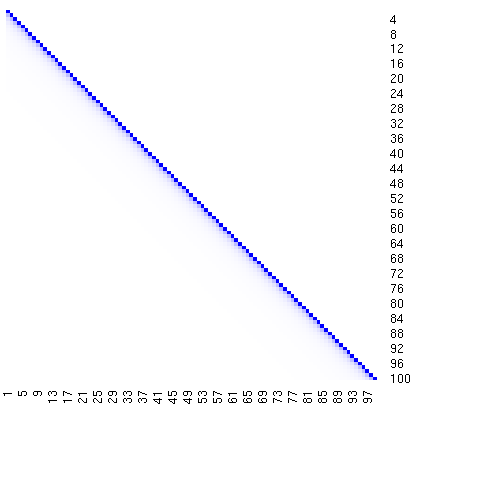

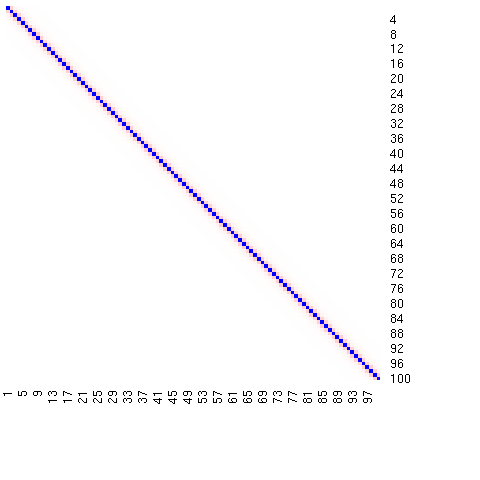

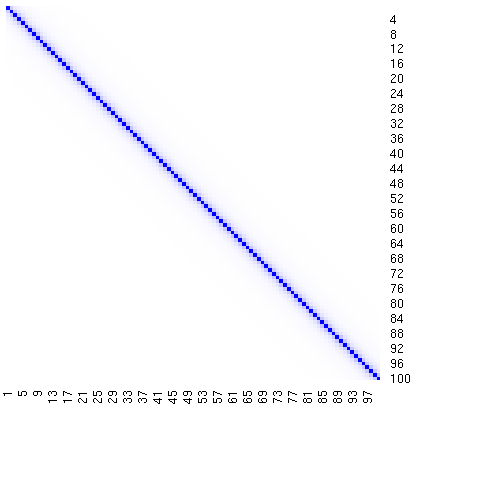

In [16]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(beta.T)
imshow(Omega.T[[1]])
imshow(Sigma.T[[1]])

# 3. simulation data according to MGGM

In [17]:
data = lapply(1:m, function(l){
    n_l = n #floor(runif(1, n, 2*n))
    return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
        sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
    }), c(p,q,n_l)))
})

In [18]:
ns = sapply(data, function(x){dim(x)[3]})

In [19]:
sess.id = c(sapply(1:m, function(l){rep(l,ns[l])}))

In [20]:
T.S = Reduce(f = "+", lapply(1:m, function(l){
    sqrt(ns[l] * p / m) * Rho.S[[l]]
}), accumulate=FALSE)

# 4. estimation by the proposed method

In [21]:
est.T = est.temporal(data, order.T=5)

In [22]:
est.S = est.spatial(data, lambdas=1e-4)

# 5. global test for multiple edges

In [23]:
num.bst = 3000

## 5.1. $E_\text{off}$

In [24]:
E.mat.off = (diag(q) == 0)
E.mat.off[lower.tri(E.mat.off, diag = TRUE)] = 0
E.mat.off = E.mat.off != 0
num.E.off = sum(1*E.mat.off)
Cov.T.E.off = cov.multiple.edge(Omega.S, Sigma.T, ns, E.mat = E.mat.off)

In [25]:
inf.S.multi.off = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                E.mat = E.mat.off, num.bst=num.bst)

### error distribution of test statistic estimate

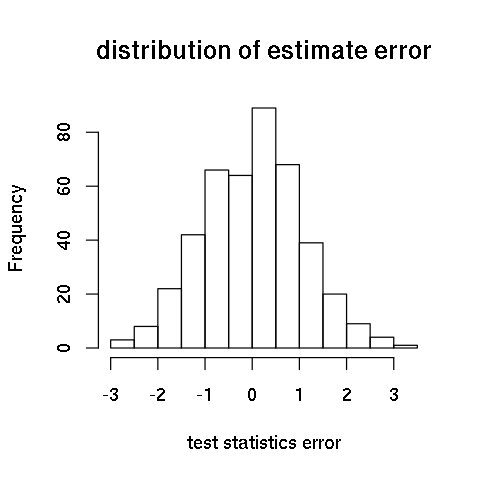

In [26]:
hist(inf.S.multi.off$T.hat.E[,1] - T.S[E.mat.off], 
     main = 'distribution of estimate error',
     xlab = 'test statistics error')

### bootstrap distribution

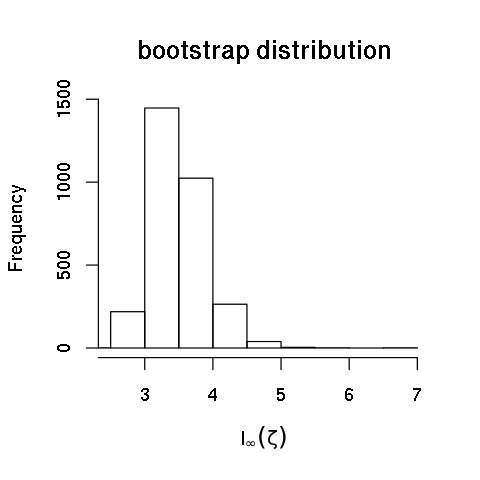

In [27]:
hist(inf.S.multi.off$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(2.5, 7), xaxt="n")
abline(v = max(abs(inf.S.multi.off$T.hat.E[,1])), col='red')
axis(side=1, at=c(2, 3, 4, 5, 6, 7))

### p-value

In [28]:
inf.S.multi.off$p.value

[1] 0

## $E_\text{zero}$

In [29]:
E.mat.zero = !Adj.S
diag(E.mat.zero) = FALSE
E.mat.zero[lower.tri(E.mat.zero, diag = TRUE)] = 0
E.mat.zero = E.mat.zero != 0
num.E.zero = sum(1*E.mat.zero)
Cov.T.E.zero = cov.multiple.edge(Omega.S, Sigma.T, ns, E.mat = E.mat.zero)

In [30]:
inf.S.multi.zero = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                     E.mat = E.mat.zero, num.bst=num.bst)

### error distribution of test statistic estimate

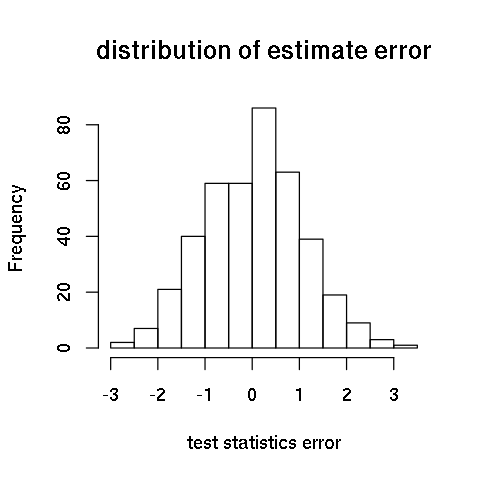

In [31]:
hist(inf.S.multi.zero$T.hat.E[,1] - T.S[E.mat.zero], 
     main = 'distribution of estimate error',
     xlab = 'test statistics error')

### bootstrap distribution

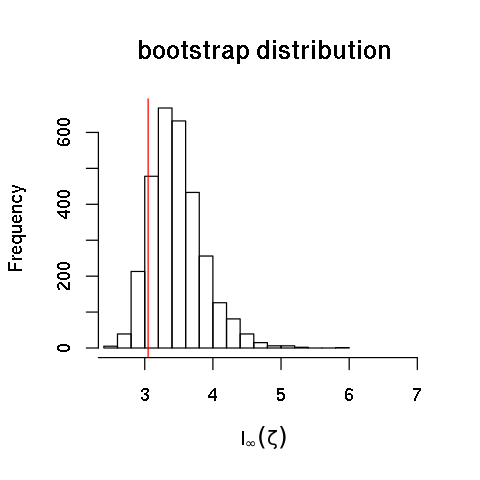

In [32]:
hist(inf.S.multi.zero$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(2.5, 7), xaxt="n")
abline(v = max(abs(inf.S.multi.zero$T.hat.E[,1])), col='red')
axis(side=1, at=c(2, 3, 4, 5, 6, 7))

### p-value

In [33]:
inf.S.multi.zero$p.value

[1] 0.8866667

# 6. iterate simulation for empirical distirbution of test statistic

In [34]:
num.sim = 1000

In [35]:
T.hat.sim = array(0, c(q,q,num.sim))

In [37]:
for( i.sim in 1:num.sim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.single.edge(est.S$W.hat.S, est.T$S.hat.T, ns)
    T.hat.sim[,,i.sim] = inf.S$T.hat
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  5.053 sec. 
2 -th simulation finished, lapse:  6.881 sec. 
3 -th simulation finished, lapse:  5.301 sec. 
4 -th simulation finished, lapse:  9.415 sec. 
5 -th simulation finished, lapse:  7.058 sec. 
6 -th simulation finished, lapse:  7.404 sec. 
7 -th simulation finished, lapse:  10.995 sec. 
8 -th simulation finished, lapse:  6.393 sec. 
9 -th simulation finished, lapse:  10.987 sec. 
10 -th simulation finished, lapse:  6.758 sec. 
11 -th simulation finished, lapse:  7.391 sec. 
12 -th simulation finished, lapse:  7.065 sec. 
13 -th simulation finished, lapse:  7.678 sec. 
14 -th simulation finished, lapse:  8.402 sec. 
15 -th simulation finished, lapse:  7.926 sec. 
16 -th simulation finished, lapse:  7.24 sec. 
17 -th simulation finished, lapse:  8.705 sec. 
18 -th simulation finished, lapse:  6.78 sec. 
19 -th simulation finished, lapse:  9.096 sec. 
20 -th simulation finished, lapse:  5.733 sec. 
21 -th simulation finished, lapse:  10.203 sec. 


171 -th simulation finished, lapse:  6.641 sec. 
172 -th simulation finished, lapse:  5.226 sec. 
173 -th simulation finished, lapse:  5.944 sec. 
174 -th simulation finished, lapse:  5.785 sec. 
175 -th simulation finished, lapse:  6.97 sec. 
176 -th simulation finished, lapse:  10.105 sec. 
177 -th simulation finished, lapse:  8.223 sec. 
178 -th simulation finished, lapse:  12.805 sec. 
179 -th simulation finished, lapse:  12.171 sec. 
180 -th simulation finished, lapse:  13.201 sec. 
181 -th simulation finished, lapse:  8.592 sec. 
182 -th simulation finished, lapse:  10.937 sec. 
183 -th simulation finished, lapse:  10.206 sec. 
184 -th simulation finished, lapse:  10.257 sec. 
185 -th simulation finished, lapse:  10.386 sec. 
186 -th simulation finished, lapse:  9.504 sec. 
187 -th simulation finished, lapse:  7.106 sec. 
188 -th simulation finished, lapse:  12.206 sec. 
189 -th simulation finished, lapse:  7.153 sec. 
190 -th simulation finished, lapse:  9.176 sec. 
191 -th simu

337 -th simulation finished, lapse:  10.954 sec. 
338 -th simulation finished, lapse:  11.163 sec. 
339 -th simulation finished, lapse:  10.477 sec. 
340 -th simulation finished, lapse:  11.222 sec. 
341 -th simulation finished, lapse:  14.649 sec. 
342 -th simulation finished, lapse:  10.22 sec. 
343 -th simulation finished, lapse:  10.342 sec. 
344 -th simulation finished, lapse:  10.537 sec. 
345 -th simulation finished, lapse:  9.497 sec. 
346 -th simulation finished, lapse:  8.696 sec. 
347 -th simulation finished, lapse:  10.716 sec. 
348 -th simulation finished, lapse:  11.229 sec. 
349 -th simulation finished, lapse:  9.766 sec. 
350 -th simulation finished, lapse:  9.283 sec. 
351 -th simulation finished, lapse:  13.552 sec. 
352 -th simulation finished, lapse:  9.062 sec. 
353 -th simulation finished, lapse:  8.138 sec. 
354 -th simulation finished, lapse:  14.247 sec. 
355 -th simulation finished, lapse:  11.948 sec. 
356 -th simulation finished, lapse:  8.793 sec. 
357 -th 

503 -th simulation finished, lapse:  13.108 sec. 
504 -th simulation finished, lapse:  7.827 sec. 
505 -th simulation finished, lapse:  11.589 sec. 
506 -th simulation finished, lapse:  9.81 sec. 
507 -th simulation finished, lapse:  9.287 sec. 
508 -th simulation finished, lapse:  8.211 sec. 
509 -th simulation finished, lapse:  9.298 sec. 
510 -th simulation finished, lapse:  8.203 sec. 
511 -th simulation finished, lapse:  9.585 sec. 
512 -th simulation finished, lapse:  7.403 sec. 
513 -th simulation finished, lapse:  11.543 sec. 
514 -th simulation finished, lapse:  10.285 sec. 
515 -th simulation finished, lapse:  10.427 sec. 
516 -th simulation finished, lapse:  11.264 sec. 
517 -th simulation finished, lapse:  10.495 sec. 
518 -th simulation finished, lapse:  8.654 sec. 
519 -th simulation finished, lapse:  11.531 sec. 
520 -th simulation finished, lapse:  8.934 sec. 
521 -th simulation finished, lapse:  10.741 sec. 
522 -th simulation finished, lapse:  11.116 sec. 
523 -th sim

679 -th simulation finished, lapse:  10.046 sec. 
680 -th simulation finished, lapse:  9.668 sec. 
681 -th simulation finished, lapse:  10.889 sec. 
682 -th simulation finished, lapse:  13.711 sec. 
683 -th simulation finished, lapse:  13.575 sec. 
684 -th simulation finished, lapse:  9.441 sec. 
685 -th simulation finished, lapse:  9.312 sec. 
686 -th simulation finished, lapse:  8.516 sec. 
687 -th simulation finished, lapse:  10.6 sec. 
688 -th simulation finished, lapse:  10.519 sec. 
689 -th simulation finished, lapse:  8.64 sec. 
690 -th simulation finished, lapse:  9.421 sec. 
691 -th simulation finished, lapse:  10.334 sec. 
692 -th simulation finished, lapse:  11.08 sec. 
693 -th simulation finished, lapse:  10.517 sec. 
694 -th simulation finished, lapse:  11.289 sec. 
695 -th simulation finished, lapse:  11.112 sec. 
696 -th simulation finished, lapse:  10.033 sec. 
697 -th simulation finished, lapse:  12.736 sec. 
698 -th simulation finished, lapse:  9.366 sec. 
699 -th sim

846 -th simulation finished, lapse:  13.725 sec. 
847 -th simulation finished, lapse:  11.383 sec. 
848 -th simulation finished, lapse:  10.429 sec. 
849 -th simulation finished, lapse:  9.796 sec. 
850 -th simulation finished, lapse:  11.801 sec. 
851 -th simulation finished, lapse:  11.63 sec. 
852 -th simulation finished, lapse:  11.941 sec. 
853 -th simulation finished, lapse:  9.988 sec. 
854 -th simulation finished, lapse:  7.598 sec. 
855 -th simulation finished, lapse:  9.568 sec. 
856 -th simulation finished, lapse:  9.85 sec. 
857 -th simulation finished, lapse:  8.974 sec. 
858 -th simulation finished, lapse:  5.664 sec. 
859 -th simulation finished, lapse:  8.088 sec. 
860 -th simulation finished, lapse:  11.135 sec. 
861 -th simulation finished, lapse:  13.906 sec. 
862 -th simulation finished, lapse:  10.515 sec. 
863 -th simulation finished, lapse:  6.776 sec. 
864 -th simulation finished, lapse:  9.103 sec. 
865 -th simulation finished, lapse:  12.533 sec. 
866 -th simu

## empirical distribution of simulated test statistics

In [38]:
T.hat.E.off = apply(T.hat.sim, 3, function(T.hat){ T.hat[E.mat.off] })
l.inf.T.off = apply(T.hat.E.off, 2, function(T.hat){ max(abs(T.hat)) })

In [39]:
l.inf.dT.off = apply(T.hat.E.off - T.S[E.mat.off],
                     2, function(T.hat){ max(abs(T.hat)) })

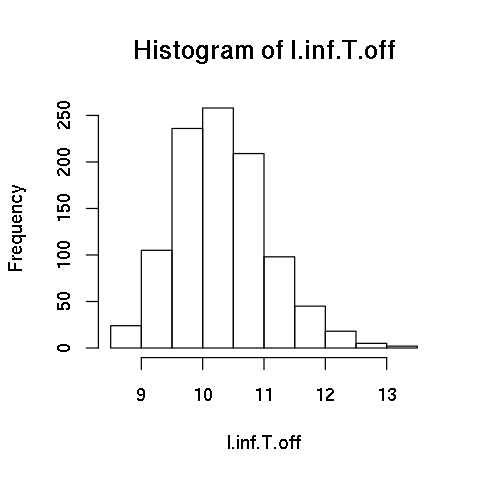

In [40]:
hist(l.inf.T.off)

In [41]:
T.hat.E.zero = apply(T.hat.sim, 3, function(T.hat){ T.hat[E.mat.zero] })
l.inf.T.zero = apply(T.hat.E.zero, 2, function(T.hat){ max(abs(T.hat)) })

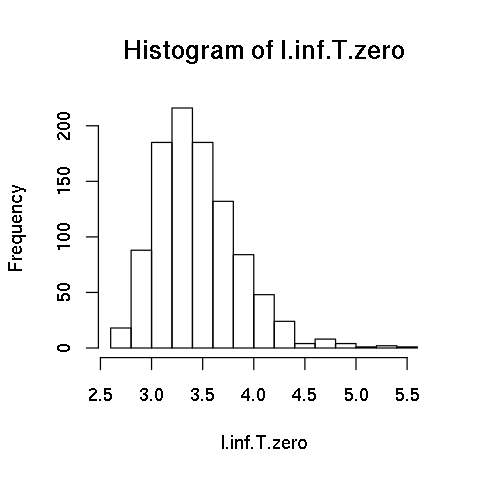

In [42]:
hist(l.inf.T.zero)

## comparison between simulation and bootstrap distributions

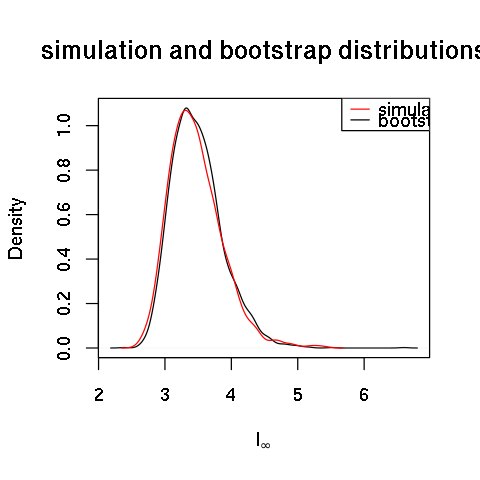

In [43]:
plot(density(inf.S.multi.off$l.inf.Z), col='black',
     main = 'simulation and bootstrap distributions',
     xlab = expression(l[infinity]))
lines(density(l.inf.dT.off), col='red')
legend('topright',
       legend=c('simulation','bootstrap'), 
       col=c('red','black'), lty=c(1,1))

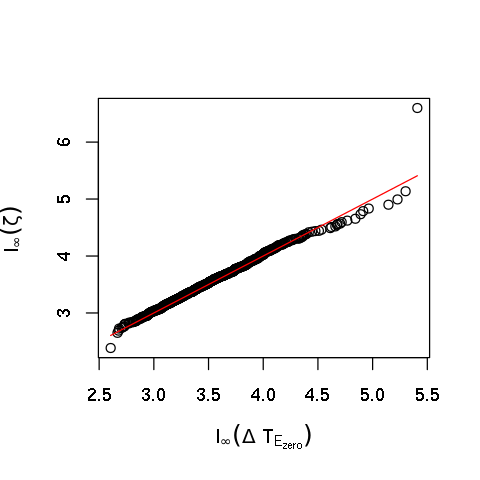

In [44]:
qqplot(l.inf.dT.off, inf.S.multi.off$l.inf.Z,
       xlab=expression(l[infinity](Delta~T[E[zero]])),
       ylab=expression(l[infinity](zeta)))
lines(l.inf.dT.off, l.inf.dT.off, col='red')

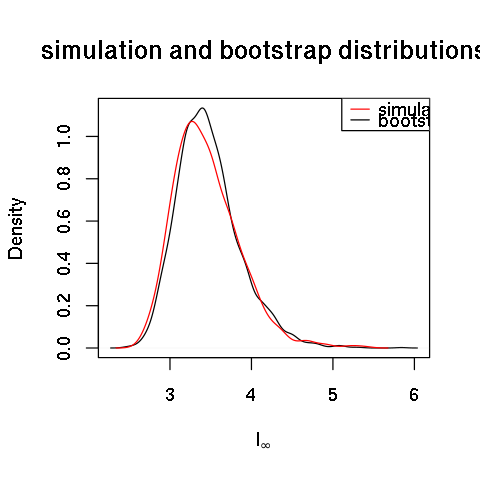

In [45]:
plot(density(inf.S.multi.zero$l.inf.Z), col='black',
     main = 'simulation and bootstrap distributions',
     xlab = expression(l[infinity]))
lines(density(l.inf.T.zero), col='red')
legend('topright',
       legend=c('simulation','bootstrap'), 
       col=c('red','black'), lty=c(1,1))

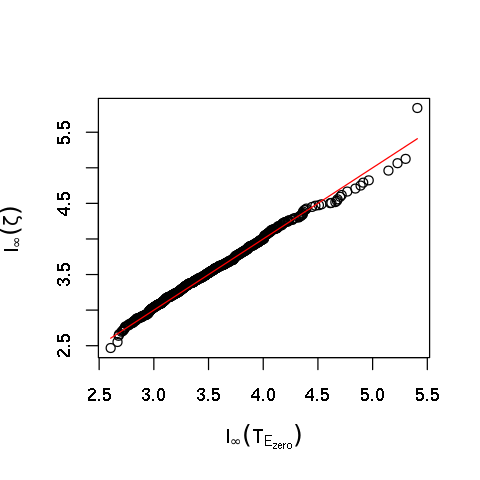

In [46]:
qqplot(l.inf.T.zero, inf.S.multi.zero$l.inf.Z,
       xlab=expression(l[infinity](T[E[zero]])),
       ylab=expression(l[infinity](zeta)))
lines(l.inf.T.zero, l.inf.T.zero, col='red')

In [47]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      inf.S.multi.off, inf.S.multi.zero, 
#      T.hat.sim, file='sim_hub_multi.Rdata')

# 7. Coverage study

In [48]:
num.msim = 100

## $E_\text{off}$

In [49]:
T.hat.E.sim = array(0, c(num.E.off,num.msim))
l.inf.Z.sim = array(0, c(num.bst,num.msim))
p.value.sim = rep(0, num.msim)

In [50]:
for( i.sim in 1:num.msim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                              E.mat=E.mat.off, num.bst=num.bst)
    
    T.hat.E.sim[,i.sim] = inf.S$T.hat.E
    l.inf.Z.sim[,i.sim] = inf.S$l.inf.Z
    p.value.sim[i.sim] = inf.S$p.value
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  18.88 sec. 
2 -th simulation finished, lapse:  20.886 sec. 
3 -th simulation finished, lapse:  20.579 sec. 
4 -th simulation finished, lapse:  20.942 sec. 
5 -th simulation finished, lapse:  19.769 sec. 
6 -th simulation finished, lapse:  20.031 sec. 
7 -th simulation finished, lapse:  20.709 sec. 
8 -th simulation finished, lapse:  20.124 sec. 
9 -th simulation finished, lapse:  19.935 sec. 
10 -th simulation finished, lapse:  20.21 sec. 
11 -th simulation finished, lapse:  19.924 sec. 
12 -th simulation finished, lapse:  20.56 sec. 
13 -th simulation finished, lapse:  20.103 sec. 
14 -th simulation finished, lapse:  19.386 sec. 
15 -th simulation finished, lapse:  19.265 sec. 
16 -th simulation finished, lapse:  19.956 sec. 
17 -th simulation finished, lapse:  18.936 sec. 
18 -th simulation finished, lapse:  19.395 sec. 
19 -th simulation finished, lapse:  19.577 sec. 
20 -th simulation finished, lapse:  18.997 sec. 
21 -th simulation finished, laps

In [52]:
# l.inf.dT.sim = apply(T.hat.E.sim - T.S[E.mat.off],
#                      2, function(T.hat){ max(abs(T.hat)) })

In [51]:
q.Z.sim = apply(l.inf.Z.sim, 2, function(l){
    quantile(l, c(0.925, 0.95, 0.975))
})

In [52]:
q.dT.sim = apply(q.Z.sim, 2, function(q){
    sapply(q, function(x){ mean(l.inf.dT.off < x) })
})

In [53]:
apply(q.dT.sim, 1, mean)

92.5%     95%   97.5% 
0.93758 0.95690 0.97746

In [54]:
apply(q.dT.sim, 1, sd)

92.5%         95%       97.5% 
0.004332587 0.003740307 0.003571549

In [56]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      E.mat.off, l.inf.dT.off, l.inf.Z.sim, p.value.sim,
#      file='sim_hub_multi_off.Rdata')

## $E_\text{zero}$

In [57]:
T.hat.E.sim = array(0, c(num.E.zero,num.msim))
l.inf.Z.sim = array(0, c(num.bst,num.msim))
p.value.sim = rep(0, num.msim)

In [58]:
for( i.sim in 1:num.msim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                              E.mat=E.mat.zero, num.bst=num.bst)
    
    T.hat.E.sim[,i.sim] = inf.S$T.hat.E
    l.inf.Z.sim[,i.sim] = inf.S$l.inf.Z
    p.value.sim[i.sim] = inf.S$p.value
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  18.048 sec. 
2 -th simulation finished, lapse:  21.449 sec. 
3 -th simulation finished, lapse:  19.118 sec. 
4 -th simulation finished, lapse:  20.927 sec. 
5 -th simulation finished, lapse:  22.134 sec. 
6 -th simulation finished, lapse:  19.36 sec. 
7 -th simulation finished, lapse:  21.542 sec. 
8 -th simulation finished, lapse:  21.541 sec. 
9 -th simulation finished, lapse:  20.429 sec. 
10 -th simulation finished, lapse:  24.041 sec. 
11 -th simulation finished, lapse:  20.332 sec. 
12 -th simulation finished, lapse:  22.072 sec. 
13 -th simulation finished, lapse:  20.983 sec. 
14 -th simulation finished, lapse:  18.966 sec. 
15 -th simulation finished, lapse:  20.629 sec. 
16 -th simulation finished, lapse:  19.402 sec. 
17 -th simulation finished, lapse:  19.331 sec. 
18 -th simulation finished, lapse:  18.459 sec. 
19 -th simulation finished, lapse:  21.002 sec. 
20 -th simulation finished, lapse:  18.019 sec. 
21 -th simulation finished, la

168 -th simulation finished, lapse:  18.265 sec. 
169 -th simulation finished, lapse:  18.483 sec. 
170 -th simulation finished, lapse:  18.12 sec. 
171 -th simulation finished, lapse:  17.798 sec. 
172 -th simulation finished, lapse:  18.968 sec. 
173 -th simulation finished, lapse:  17.615 sec. 
174 -th simulation finished, lapse:  18.158 sec. 
175 -th simulation finished, lapse:  17.487 sec. 
176 -th simulation finished, lapse:  18.221 sec. 
177 -th simulation finished, lapse:  17.765 sec. 
178 -th simulation finished, lapse:  18.442 sec. 
179 -th simulation finished, lapse:  18.491 sec. 
180 -th simulation finished, lapse:  17.618 sec. 
181 -th simulation finished, lapse:  18.769 sec. 
182 -th simulation finished, lapse:  17.517 sec. 
183 -th simulation finished, lapse:  19.24 sec. 
184 -th simulation finished, lapse:  18.319 sec. 
185 -th simulation finished, lapse:  18.198 sec. 
186 -th simulation finished, lapse:  18.487 sec. 
187 -th simulation finished, lapse:  17.398 sec. 
18

In [ ]:
# l.inf.dT.sim = apply(T.hat.E.sim - T.S[E.mat.off],
#                      2, function(T.hat){ max(abs(T.hat)) })

In [60]:
q.Z.sim = apply(l.inf.Z.sim, 2, function(l){
    quantile(l, c(0.925, 0.95, 0.975))
})

In [61]:
q.dT.sim = apply(q.Z.sim, 2, function(q){
    sapply(q, function(x){ mean(l.inf.T.zero < x) })
})

In [62]:
apply(q.dT.sim, 1, mean)

92.5%     95%   97.5% 
0.93653 0.95661 0.97824

In [63]:
apply(q.dT.sim, 1, sd)

92.5%         95%       97.5% 
0.005141346 0.004187270 0.002621280

In [64]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      E.mat.zero, l.inf.T.zero, l.inf.Z.sim, p.value.sim,
#      file='sim_hub_multi_zero.Rdata')